In [1]:
import os
!nvidia-smi

Sun Mar 31 16:02:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:65:00.0  On |                  N/A |
| 24%   56C    P0    67W / 250W |    435MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# !pip install pretrainedmodels

In [2]:
from torchvision.models import *
import pretrainedmodels

from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
import fastai
import sys
import torch

In [3]:
path = "/home/aiml/ml/share/data/intel/scene_classification/train/"

In [4]:
fastai.__version__

'1.0.50.post1'

In [5]:
torch.__version__

'1.0.1.post2'

In [6]:
bs = 8

In [7]:
df = pd.read_csv('/home/aiml/ml/share/data/intel/scene_classification/train.csv')
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [8]:
import os
filenames = os.listdir('/home/aiml/ml/share/data/intel/scene_classification/test/')

In [9]:
tfms = get_transforms(flip_vert=False,max_zoom=1.1,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '../train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '../test')              
        .transform(tfms, size=150)
        .databunch(num_workers=0))

In [13]:
# Function that returns an image from its url
def get_img(img_url): return open_image(img_url)

# Function that displays many transformations of an image
def plots_of_one_image(img_url, tfms, rows=1, cols=3, width=15, height=5, **kwargs):
    img = get_img(img_url)
    [img.apply_tfms(tfms, **kwargs).show(ax=ax)
         for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]
    
# Function that displays one image after transformations
def display_img_after_tfms(img_url, tfms, ax, label):
        img = get_img(img_url).apply_tfms(tfms=tfms, size=224)
        img.show(ax=ax)
        ax.set_title(x=0.5,y=-0.1, label=label)

In [17]:
# get list of images
fnames = get_image_files(path)
img_url = fnames[2]
img_url.name

'11751.jpg'

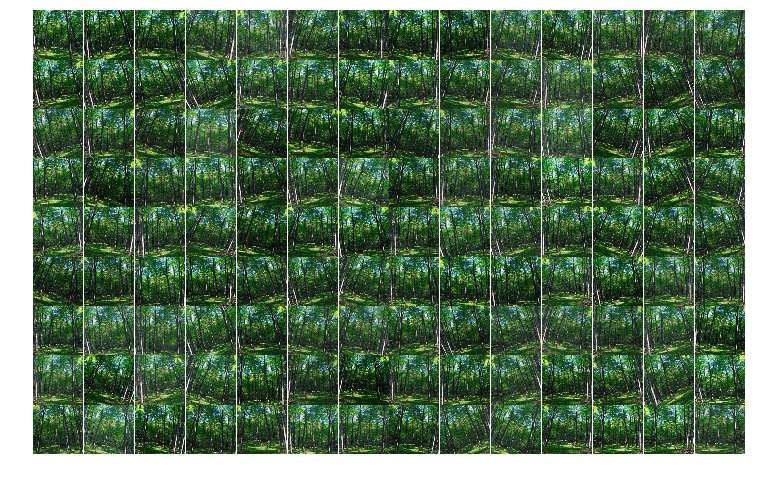

In [15]:
tfms = get_transforms(flip_vert=False,                # flip vertical and horizontal
                      max_rotate=20.0,                # rotation between -30° and 30°
                      max_zoom=1.2)                   # zoom between 1 and 1.2
plots_of_one_image(img_url,tfms[0],9,14,11,7, size=200)
plt.subplots_adjust(left=0, bottom=0,wspace=0, hspace=0)
plt.show()

In [17]:
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10.0,
                      max_zoom=1.1,
                      max_warp=0.2,
                      p_affine=0.75,
                      max_lighting=0.2,
                      p_lighting=0.75,
                      xtra_tfms=None
                     )

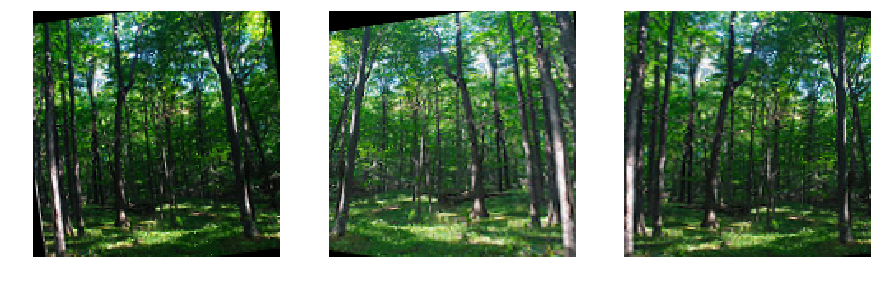

In [20]:
tfms = get_transforms()
plots_of_one_image(img_url,tfms[0],size=150,padding_mode='zeros')

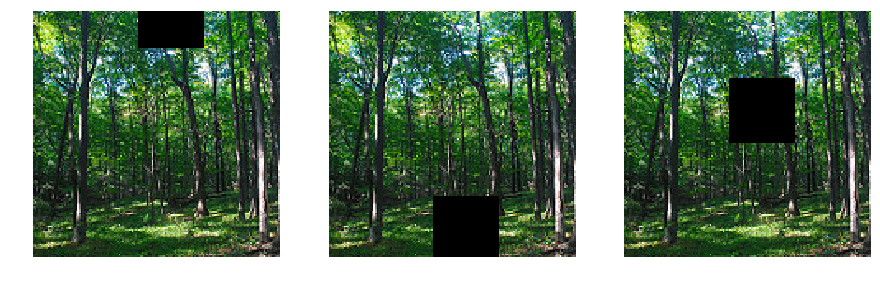

In [23]:
# tfms = [cutout(n_holes=(1,4), length=(5, 16), p=1.)]
tfms = [cutout()]
plots_of_one_image(img_url,tfms)

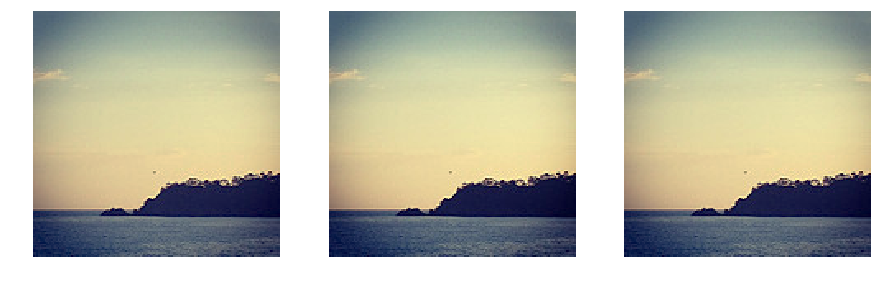

In [21]:
tfms = [contrast(scale=(0.5, 1.), p=5.)]
plots_of_one_image(img_url,tfms)

In [25]:
tfms = [cutout(n_holes=(1,4), length=(10, 160), p=1.)]
plots_of_one_image(data,tfms)

AttributeError: read

In [ ]:
data.show_batch(rows=3, figsize=(8,10))

In [10]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [10]:
## Start Modelling
def resnet18():
    arch = 'resnet18'
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)

    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return nn.Sequential(*model.children())

learn1 = create_cnn(data, resnet18, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][6], m[1]))

/home/aiml/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
def resnet50():
    arch = 'resnet50'
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)
    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return nn.Sequential(*model.children())

learn2 = create_cnn(data, resnet50, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][6], m[1]))

In [11]:
learn1.fit_one_cycle(6) 
learn1.unfreeze()
learn1.lr_find()
learn1.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.380288,0.218341,0.078097,0.921903,00:54
1,0.307846,0.199587,0.069583,0.930417,00:54
2,0.247735,0.185117,0.064592,0.935408,00:53
3,0.224833,0.174206,0.058720,0.941280,00:53
4,0.214115,0.169140,0.058426,0.941574,00:53
5,0.187857,0.165650,0.059894,0.940106,00:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.181090,0.165313,0.059894,0.940106,00:57
1,0.181541,0.160859,0.057546,0.942455,00:57
2,0.164933,0.158689,0.055784,0.944216,00:56
3,0.155484,0.157787,0.056958,0.943042,00:57
4,0.153066,0.157914,0.056078,0.943922,00:57
5,0.152853,0.157208,0.054022,0.945978,00:57


In [12]:
learn2.fit_one_cycle(6) 
learn2.unfreeze()
learn2.lr_find()
learn2.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.324498,0.208692,0.075161,0.924839,01:09
1,0.251829,0.172914,0.065766,0.934234,01:07
2,0.213742,0.181640,0.065473,0.934527,01:07
3,0.186977,0.147011,0.051086,0.948914,01:07
4,0.163171,0.144242,0.049618,0.950382,01:07
5,0.153609,0.140328,0.048150,0.951850,01:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.151340,0.138105,0.046389,0.953611,01:17
1,0.145334,0.136499,0.046682,0.953318,01:17
2,0.128561,0.137852,0.047270,0.952730,01:17
3,0.117011,0.137980,0.048738,0.951262,01:18
4,0.095764,0.136498,0.047270,0.952730,01:17
5,0.107081,0.136338,0.046389,0.953611,01:17


In [15]:
## Save the predictions for later use
torch.save(preds1,'tensor_preds2_contrast')

In [59]:
torch.save(preds1,'tensor_preds1')
torch.save(preds2,'tensor_preds2')
torch.save(preds11,'tensor_preds11')

In [58]:
torch.load('tensor_preds11').shape

torch.Size([7301, 6])

In [29]:
preds1,_ = learn1.TTA(ds_type=DatasetType.Test)
preds2,_ = learn2.TTA(ds_type=DatasetType.Test)

## Weighted average of the prob.
pred1 = preds1 + preds2

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('submission.csv',index=False)

In [46]:
del learn1
del learn2
torch.cuda.empty_cache()

**Changing image resolution to 256**

In [26]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False)
data = (ImageList.from_csv(path, csv_name = '../train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '../test')              
        .transform(tfms, size=256)
        .databunch(num_workers=0))

In [14]:
def resnet18():
    arch = 'resnet18'
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)

    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return nn.Sequential(*model.children())

learn4 = create_cnn(data, resnet18, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][6], m[1]))

def resnet50():
    pretrained = 'imagenet' if pretrained else None
    arch = 'resnet50'
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)
    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return nn.Sequential(*model.children())

learn5 = create_cnn(data, resnet50, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][6], m[1]))

/home/aiml/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [15]:
learn4.fit_one_cycle(6) 
learn4.unfreeze()
learn4.lr_find()
learn4.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.317316,0.194712,0.068409,0.931591,01:32
1,0.249122,0.173107,0.065179,0.934821,01:31
2,0.211817,0.163417,0.058426,0.941574,01:31
3,0.172128,0.157853,0.056371,0.943629,01:31
4,0.159688,0.148401,0.054316,0.945684,01:31
5,0.143965,0.147594,0.054316,0.945684,01:31


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.143364,0.145723,0.049912,0.950088,01:38
1,0.129948,0.145088,0.051674,0.948326,01:38
2,0.123733,0.144403,0.050499,0.949501,01:37
3,0.109124,0.142482,0.049031,0.950969,01:37
4,0.103787,0.140673,0.050499,0.949501,01:38
5,0.096973,0.140495,0.048150,0.951850,01:37


In [21]:
learn5.fit_one_cycle(6) 
learn5.unfreeze()
learn5.lr_find()
learn5.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.262694,0.193080,0.066060,0.933940,02:23
1,0.211143,0.187318,0.063711,0.936289,02:21
2,0.194873,0.152901,0.054316,0.945684,02:21
3,0.141615,0.157119,0.054022,0.945978,02:21
4,0.113967,0.146200,0.047857,0.952143,02:21
5,0.106780,0.147879,0.047857,0.952143,02:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.103677,0.146432,0.049618,0.950382,02:41
1,0.094086,0.146669,0.050206,0.949794,02:41
2,0.082374,0.150219,0.050206,0.949794,02:41
3,0.072884,0.151003,0.049618,0.950382,02:41
4,0.053000,0.153648,0.050499,0.949501,02:41
5,0.047189,0.154042,0.050206,0.949794,02:41


In [16]:
preds1 = torch.load('tensor_preds1')
preds2 = torch.load('tensor_preds2')
preds11 = torch.load('tensor_preds11')
preds4 = torch.load('tensor_preds4')
preds5 = torch.load('tensor_preds5')
preds1_cut = torch.load('tensor_preds2_cut')

In [25]:
preds4,_ = learn4.TTA(ds_type=DatasetType.Test)
preds5,_ = learn5.TTA(ds_type=DatasetType.Test)

pred1 = 1.5* preds1 + 2* preds2 + preds14
# pred1 = preds4  + preds5

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('submission.csv',index=False)

In [24]:
torch.save(preds4,'tensor_preds4')
torch.save(preds5,'tensor_preds5')

In [ ]:
del learn4
del learn5
torch.cuda.empty_cache()

In [27]:
learn23 = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

learn24 = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

/home/aiml/.local/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /home/aiml/.torch/models/densenet169-b2777c0a.pth
57365526it [00:34, 1681728.15it/s]


In [ ]:
learn23.lr_find()
learn23.fit_one_cycle(6) 
learn23.unfreeze()
learn23.lr_find()
learn23.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

In [ ]:
learn24.lr_find()
learn24.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 
learn24.unfreeze()
learn24.lr_find()
learn24.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

In [ ]:
preds23,_ = learn23.TTA(ds_type=DatasetType.Test)
preds24,_ = learn24.TTA(ds_type=DatasetType.Test)

pred1 = preds23 + pred24

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('submission.csv',index=False)

In [ ]:
del learn23
del learn24

In [ ]:
pred1 = preds1 + preds2 + preds4 + preds5 + preds23 + pred24

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('submission.csv',index=False)

In [1]:
##https://github.com/CSAILVision/places365/
##https://www.kaggle.com/dipam7/intel-data-scene/kernels
##http://places.csail.mit.edu/downloadCNN.html
##https://github.com/buptchan/scene-classification

##Dataset - Places2
##https://forums.fast.ai/t/lesson-5-advanced-discussion/30865/40
##https://github.com/clcarwin/convert_torch_to_pytorch
##https://blog.floydhub.com/ten-techniques-from-fast-ai/
##https://github.com/piegu/fastai-projects/blob/master/data-augmentation-by-fastai-v1.ipynb
##https://docs.fast.ai/vision.transform.html#get_transforms
